In [28]:
#
# >> imports
#

import numpy as np
import matplotlib.pyplot as plt


In [29]:
#
# >> debugs options
#

DEBUG_PHASE_0 = True
DEBUG_PHASE_1 = True
DEBUG_PHASE_2 = True
DEBUG_PHASE_3 = True
DEBUG_PHASE_4 = True
DEBUG_PHASE_5 = False
DEBUG_PHASE_6 = False
DEBUG_PHASE_7 = False
DEBUG_PHASE_8 = False
DEBUG_PHASE_9 = False


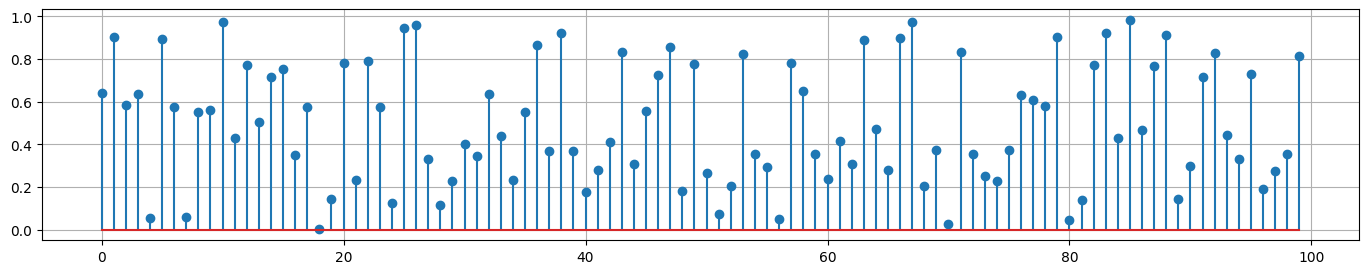

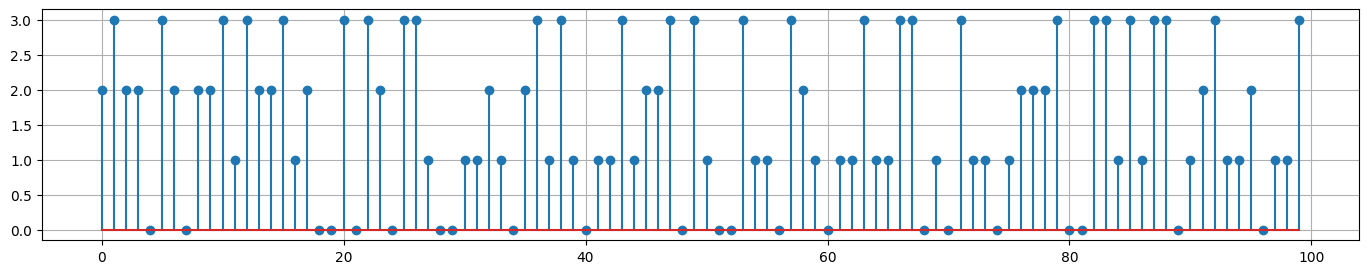

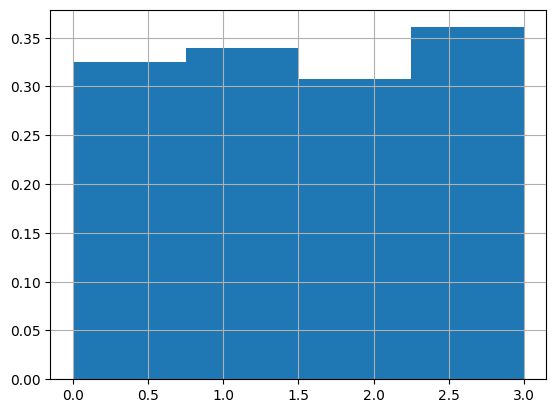

In [30]:
#
# >> hypothesis generator phase
#

HYPOTHESIS = [0, 1, 2, 3]
PROBABILITIES = [0.25, 0.25, 0.25, 0.25]
N_SAMPLES = 2**10

#
# >> generation of the hypothesis
#

z = np.random.uniform(size=N_SAMPLES)       # generates a vector of random numbers between 0 and 1
hypothesis = np.full(N_SAMPLES, 0)          # initialize the final hypothesis vector
for i in range(N_SAMPLES):                  # iterate N_SAMPLES times
    j = 0                                   # store the index of the hypothesis to be used
    accumulator = PROBABILITIES[j]          # initialize the accumulator
    while accumulator < z[i]:               # if the accumulator stills below of the generated random number, add the next probability
        j += 1                              # move to the next index of the hypothesis vector
        accumulator += PROBABILITIES[j]     # accumulate the next probability
    hypothesis[i] = HYPOTHESIS[j]           # store the final hypothesis, associated to the random number generated

#
# >> DEBUG
#

if DEBUG_PHASE_0:

    plt.figure(figsize=(17,3))
    plt.stem(z[0:100])
    plt.grid(True)
    plt.show(True)
    
    plt.figure(figsize=(17, 3))
    plt.stem(hypothesis[0:100])
    plt.grid(True)
    plt.show(True)

    plt.hist(hypothesis, bins=len(HYPOTHESIS), density=True)
    plt.grid(True)
    plt.show(True)


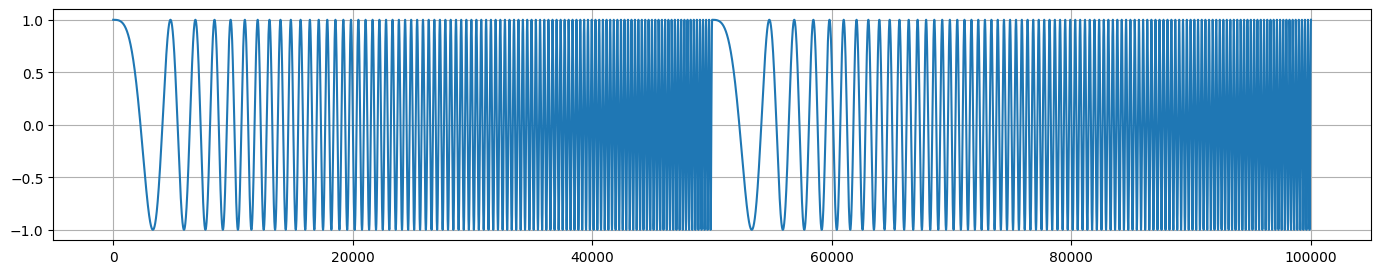

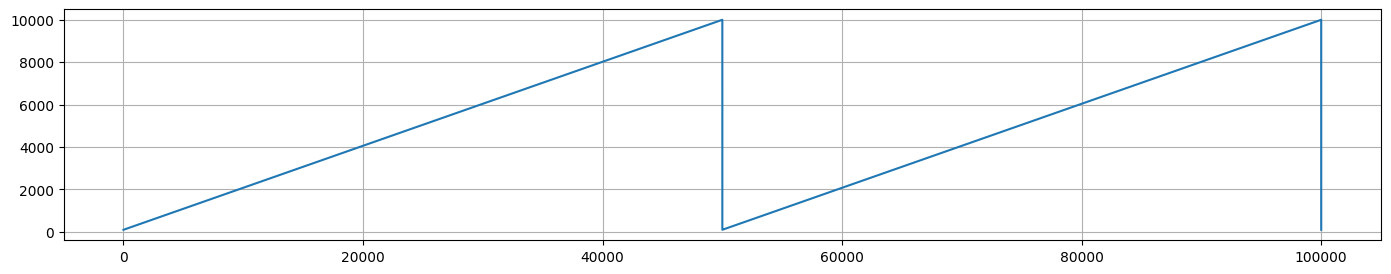

In [31]:
#
# >> base function generation phase
#

T = 10e-3           # period in [s]
START_FREQ = 10e1   # start frequency of the base function in [Hz]
END_FREQ = 10e3     # end frequncy of the base function in [Hz]

def baseFunction(time):
    time = time % T
    freq = (time / T) * (END_FREQ - START_FREQ) + START_FREQ
    return (np.cos(2 * np.pi * freq * time), freq)

#
# >> DEBUG
#

if DEBUG_PHASE_1:

    time = np.linspace(0, 2 * T, 100000)
    results = baseFunction(time)

    plt.figure(figsize=(17, 3))
    plt.plot(results[0])
    plt.grid(True)
    plt.show(True)

    plt.figure(figsize=(17, 3))
    plt.plot(results[1])
    plt.grid(True)
    plt.show(True)


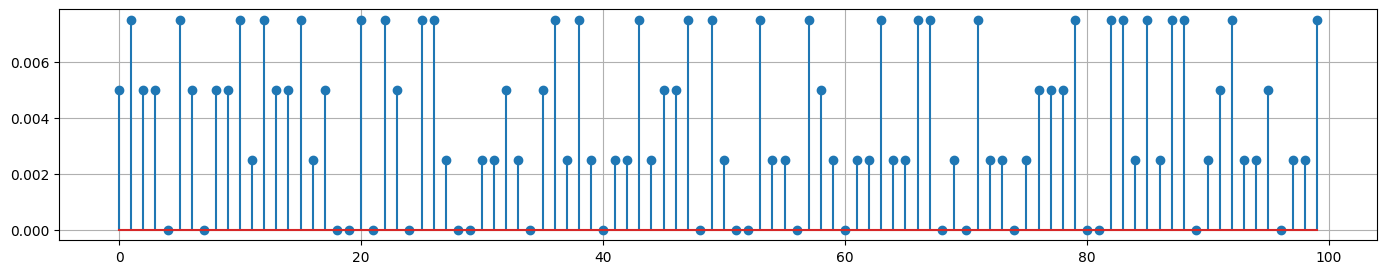

In [32]:
#
# >> encoder codeword output phase
#

DELTA_TIME_T = T / len(HYPOTHESIS)
CODEWORDS = np.full(len(HYPOTHESIS), 0.0)

#
# >> generation of the codewords
#

for i in range(len(HYPOTHESIS)):
    CODEWORDS[i] = DELTA_TIME_T * HYPOTHESIS[i]

codewords = CODEWORDS[hypothesis]

#
# >> DEBUG
#

if DEBUG_PHASE_2:

    plt.figure(figsize=(17, 3))
    plt.stem(codewords[0:100])
    plt.grid(True)
    plt.show(True)


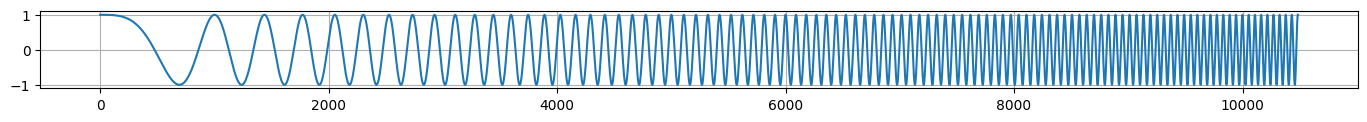

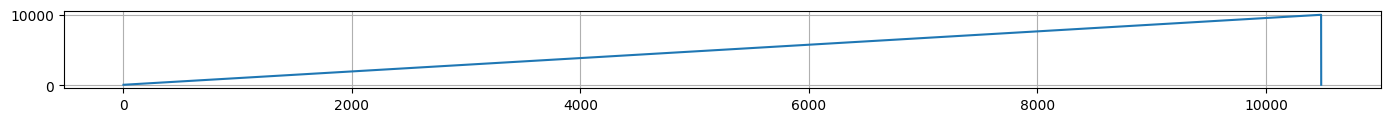

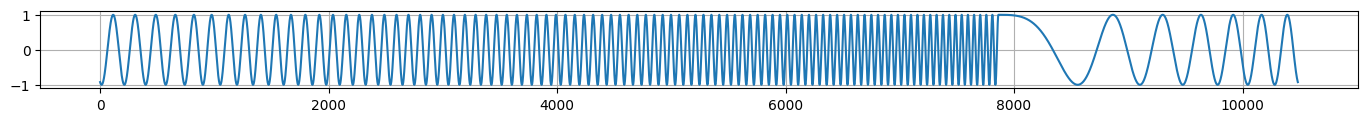

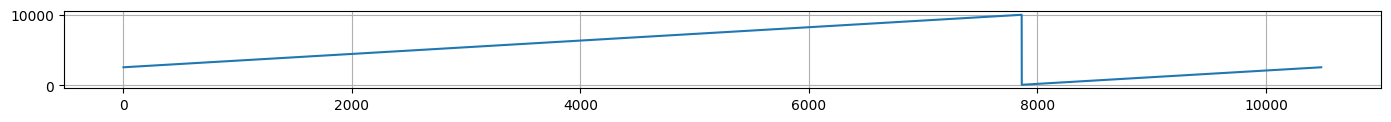

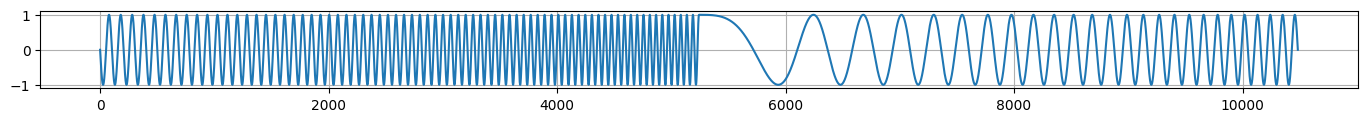

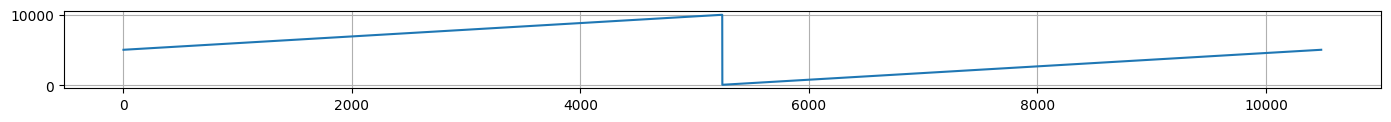

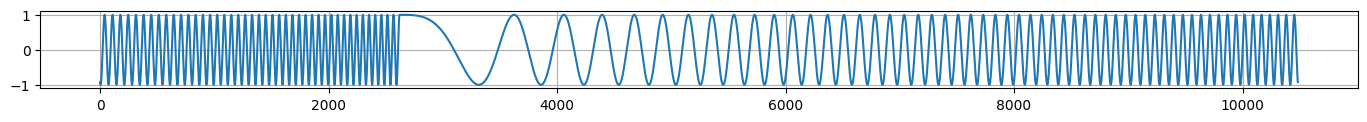

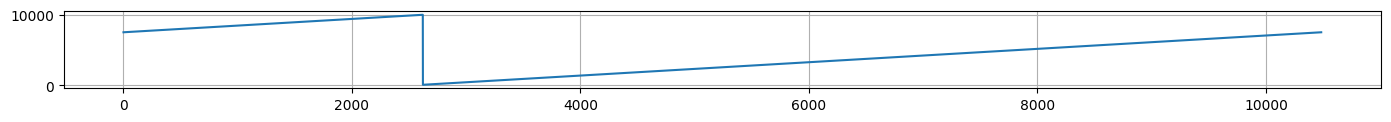

In [33]:
#
# >> waveform former function phase
#

SAMPLING_RATE = 2**20
TIME = np.linspace(0, T, int(SAMPLING_RATE * T))

def generateWaveform(codeword):
    return baseFunction(TIME + codeword)

#
# >> DEBUG
#

if DEBUG_PHASE_3:
    for i in range(len(CODEWORDS)):

        plt.figure(figsize=(17, 1))
        plt.plot(generateWaveform(CODEWORDS[i])[0])
        plt.grid(True)
        plt.show(True)

        plt.figure(figsize=(17, 1))
        plt.plot(generateWaveform(CODEWORDS[i])[1])
        plt.grid(True)
        plt.show(True)


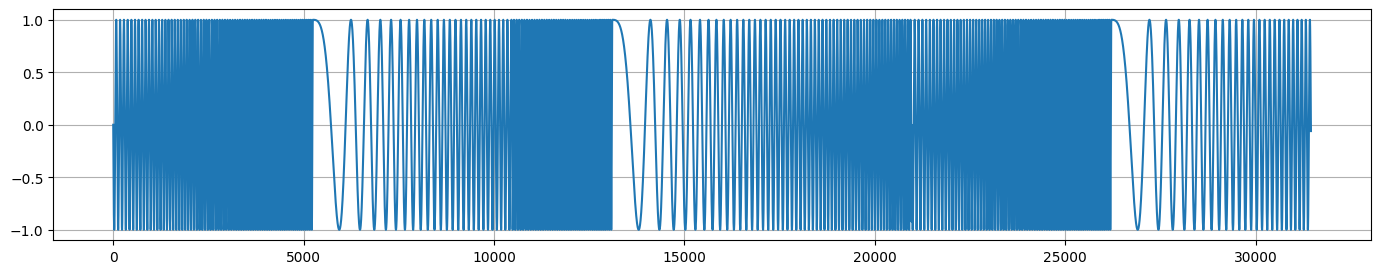

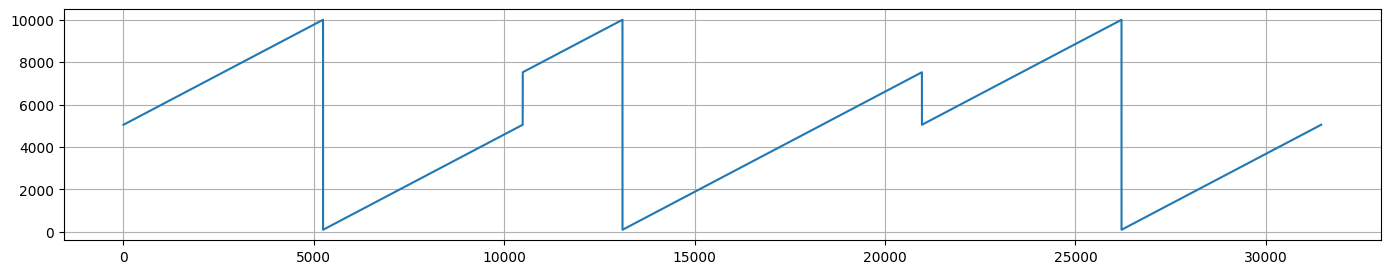

In [34]:
#
# >> waveform generation phase
#

waveform = [generateWaveform(codewords[i])[0] for i in range(len(codewords))]
waveform = np.concatenate(waveform)

waveform_freq = [generateWaveform(codewords[i])[1] for i in range(len(codewords))]
waveform_freq = np.concatenate(waveform_freq)

if DEBUG_PHASE_4:

    plt.figure(figsize=(17, 3))
    plt.plot(waveform[0:int(T * SAMPLING_RATE * 3)])
    plt.grid(True)
    plt.show(True)

    plt.figure(figsize=(17, 3))
    plt.plot(waveform_freq[0:int(T * SAMPLING_RATE * 3)])
    plt.grid(True)
    plt.show(True)


In [35]:
#
# >> additive white gaussian noise generator
#

MEAN = 0
STD_DEV = 0.55

simulated_noise = np.random.normal(MEAN, STD_DEV, len(waveform))

#
# >> DEBUG
#

if DEBUG_PHASE_5:

    plt.hist(simulated_noise, bins=1000, density=True)
    plt.grid(True)
    plt.show(True)


In [36]:
#
# >> transmission of the signal over the AWGN channel
#

transmitted_signal = waveform +simulated_noise

#
# >> DEBUG
#

if DEBUG_PHASE_6:

    plt.figure(figsize=(18, 3))
    plt.plot(transmitted_signal[0:1000])
    plt.grid(True)
    plt.show(True)

    plt.hist(transmitted_signal, bins=1000, density=True)
    plt.grid(True)
    plt.show(True)


In [37]:
#
# >> n-tuple former
#

received_signal = []
for i in range(len(transmitted_signal)):
    if i % T == 0:
        received_signal.append(transmitted_signal[i])

#
# >> DEBUG
#

if DEBUG_PHASE_7:

    plt.figure(figsize=(18, 3))
    plt.stem(received_signal[0:100])
    plt.grid(True)
    plt.show(True)


In [38]:
#
# >> MAP decoder
#

P_H0 = 1 -REF
P_H1 = REF
SIGMA_SQ = STD_DEV**2

decision = []
for signal in received_signal:
    p_x_given_h0 = (1 / np.sqrt(2 * np.pi * SIGMA_SQ)) * np.exp(-((signal -CODEWORD_0)**2) / (2 * SIGMA_SQ))
    p_x_given_h1 = (1 / np.sqrt(2 * np.pi * SIGMA_SQ)) * np.exp(-((signal -CODEWORD_1)**2) / (2 * SIGMA_SQ))
    p_h0_given_x = (p_x_given_h0 * P_H0) / ((p_x_given_h0 * P_H0) +(p_x_given_h1 * P_H1))
    p_h1_given_x = (p_x_given_h1 * P_H1) / ((p_x_given_h0 * P_H0) +(p_x_given_h1 * P_H1))
    if p_h0_given_x > p_h1_given_x:
        decision.append(HIPOTESIS_0)
    else:
        decision.append(HIPOTESIS_1)

#
# >> DEBUG
#

if DEBUG_PHASE_8:

    error_count = 0
    for hip_i, hip_j in zip(decision, hipotesis):
        if hip_i != hip_j:
            error_count += 1
    print(f'error: {error_count / len(hipotesis) * 100:.2f}%')

    plt.figure(figsize=(18, 3))
    plt.stem(decision[0:100])
    plt.grid(True)
    plt.show(True)

    plt.hist(decision, bins=10, density=True)
    plt.grid(True)
    plt.show(True)


NameError: name 'REF' is not defined

error: 3.54%


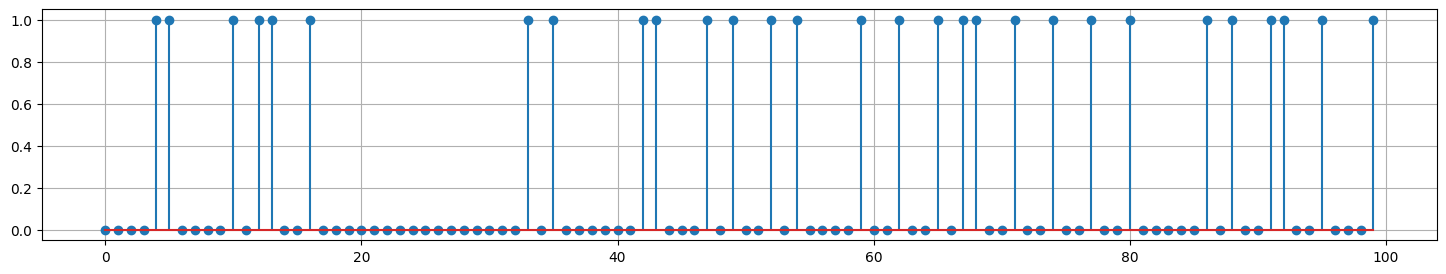

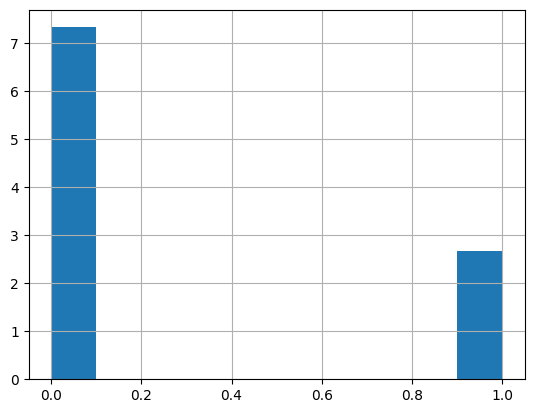

In [ ]:
#
# >> ML decoder
#

threshold = ((CODEWORD_1 -CODEWORD_0) / 2) +CODEWORD_0
decision = [HIPOTESIS_0 if received_signal[i] < threshold else HIPOTESIS_1 for i in range(len(received_signal))]

#
# >> DEBUG
#

if DEBUG_PHASE_9:

    error_count = 0
    for hip_i, hip_j in zip(decision, hipotesis):
        if hip_i != hip_j:
            error_count += 1
    print(f'error: {error_count / len(hipotesis) * 100:.2f}%')

    plt.figure(figsize=(18, 3))
    plt.stem(decision[0:100])
    plt.grid(True)
    plt.show(True)

    plt.hist(decision, bins=10, density=True)
    plt.grid(True)
    plt.show(True)
